In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_recall_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel
import optuna
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import shap
from tpot import TPOTClassifier

In [4]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.9 MB/s eta 0:00:00


In [2]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.4/383.4 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.3 MB/s eta 0:00:00


In [5]:
!pip install tpot

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.4/87.4 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 8.2 MB/s eta 0:00:00
  Created wheel for stopit: filename=stopit-1.1.2-py3-none-any.whl size=11939 sha256=b65c058706402516885c855ae20123bd4db6015043b387b51bba6c16f8c6b198
  Stored in directory: /root/.cache/pip/wheels/da/77/2d/adbc56bc4db95ad80c6d4e71cd69e2d9d122174904342e3f7f
Successfully built stopit


In [7]:
df = pd.read_csv('Breast_Cancer.csv')

In [8]:
print(df.head())

   Age   Race Marital Status T Stage  N Stage 6th Stage  \
0   68  White        Married       T1      N1       IIA   
1   50  White        Married       T2      N2      IIIA   
2   58  White       Divorced       T3      N3      IIIC   
3   58  White        Married       T1      N1       IIA   
4   47  White        Married       T2      N1       IIB   

               differentiate Grade   A Stage  Tumor Size Estrogen Status  \
0      Poorly differentiated     3  Regional           4        Positive   
1  Moderately differentiated     2  Regional          35        Positive   
2  Moderately differentiated     2  Regional          63        Positive   
3      Poorly differentiated     3  Regional          18        Positive   
4      Poorly differentiated     3  Regional          41        Positive   

  Progesterone Status  Regional Node Examined  Reginol Node Positive  \
0            Positive                      24                      1   
1            Positive                      1

In [9]:
print(df.isnull().sum())

Age                       0
Race                      0
Marital Status            0
T Stage                   0
N Stage                   0
6th Stage                 0
differentiate             0
Grade                     0
A Stage                   0
Tumor Size                0
Estrogen Status           0
Progesterone Status       0
Regional Node Examined    0
Reginol Node Positive     0
Survival Months           0
Status                    0
dtype: int64


In [10]:
print(df.describe())

               Age   Tumor Size  Regional Node Examined  \
count  4024.000000  4024.000000             4024.000000   
mean     53.972167    30.473658               14.357107   
std       8.963134    21.119696                8.099675   
min      30.000000     1.000000                1.000000   
25%      47.000000    16.000000                9.000000   
50%      54.000000    25.000000               14.000000   
75%      61.000000    38.000000               19.000000   
max      69.000000   140.000000               61.000000   

       Reginol Node Positive  Survival Months  
count            4024.000000      4024.000000  
mean                4.158052        71.297962  
std                 5.109331        22.921430  
min                 1.000000         1.000000  
25%                 1.000000        56.000000  
50%                 2.000000        73.000000  
75%                 5.000000        90.000000  
max                46.000000       107.000000  


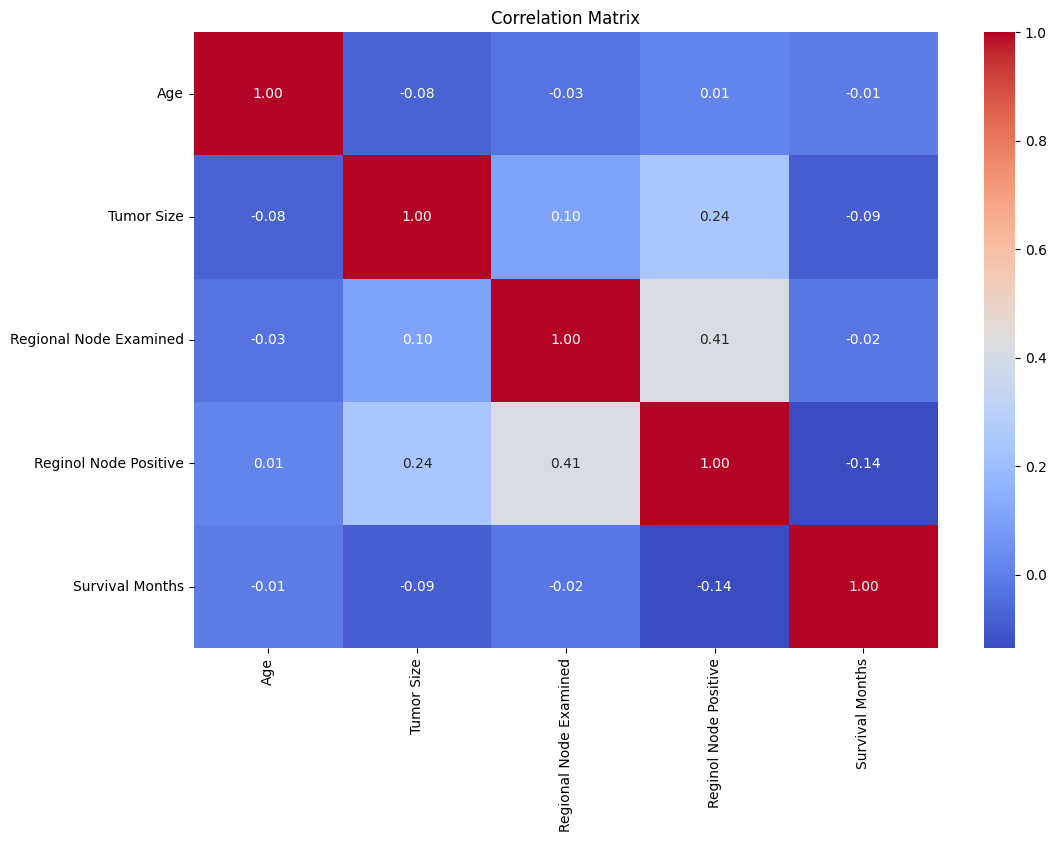

In [12]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.select_dtypes(include=np.number).corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

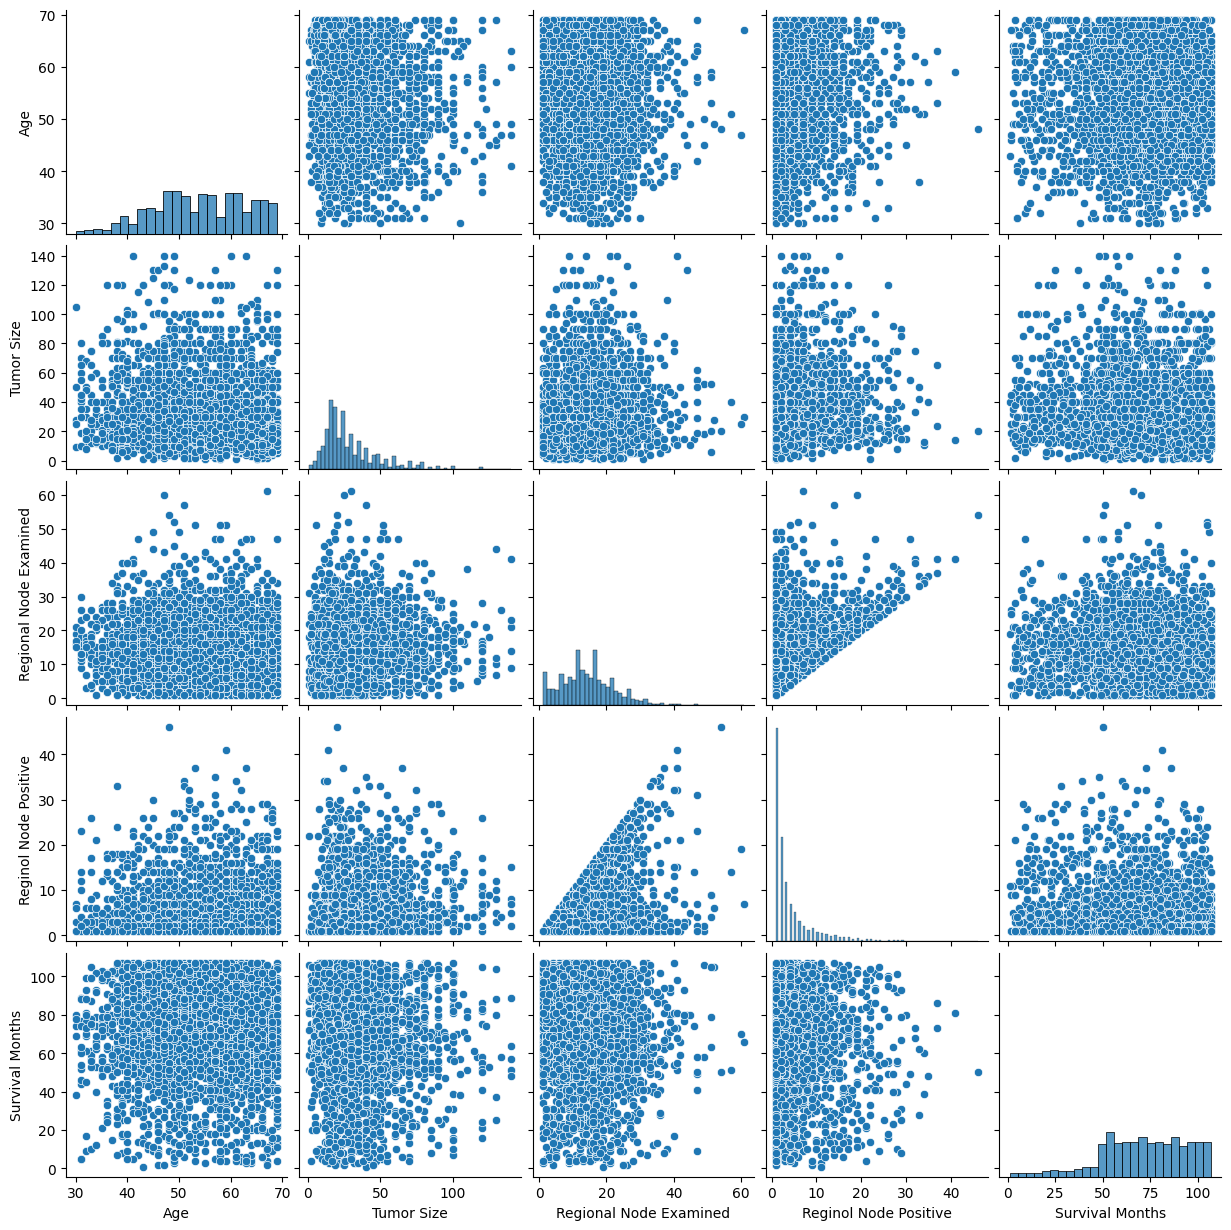

In [13]:
sns.pairplot(df[['Age', 'Tumor Size', 'Regional Node Examined', 'Reginol Node Positive', 'Survival Months']])
plt.show()

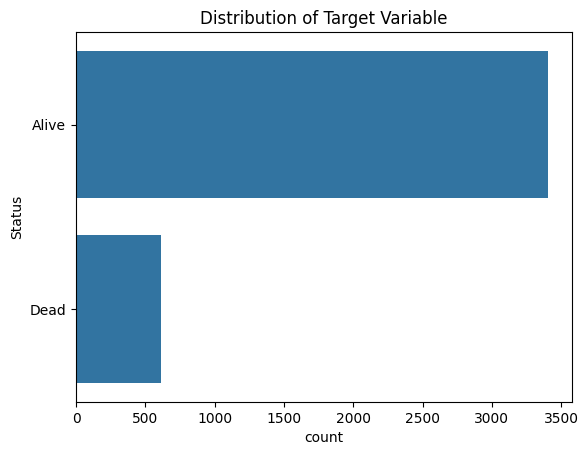

In [14]:
sns.countplot(df['Status'])
plt.title('Distribution of Target Variable')
plt.show()

In [16]:
label_encoders = {}
for column in ['Race', 'Marital Status', 'T Stage', 'N Stage', '6th Stage', 'differentiate', 'Grade', 'A Stage', 'Estrogen Status', 'Progesterone Status', 'Status']:
    actual_column_name = next((col for col in df.columns if col.strip() == column), None)
    if actual_column_name:
        le = LabelEncoder()
        df[actual_column_name] = le.fit_transform(df[actual_column_name])
        label_encoders[actual_column_name] = le
    else:
        print(f"Column '{column}' not found in DataFrame")

In [17]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df.drop('Status', axis=1))
df_scaled = pd.DataFrame(df_scaled, columns=df.columns[:-1])

In [18]:
rf = RandomForestClassifier(random_state=42)
rf.fit(df_scaled, df['Status'])
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

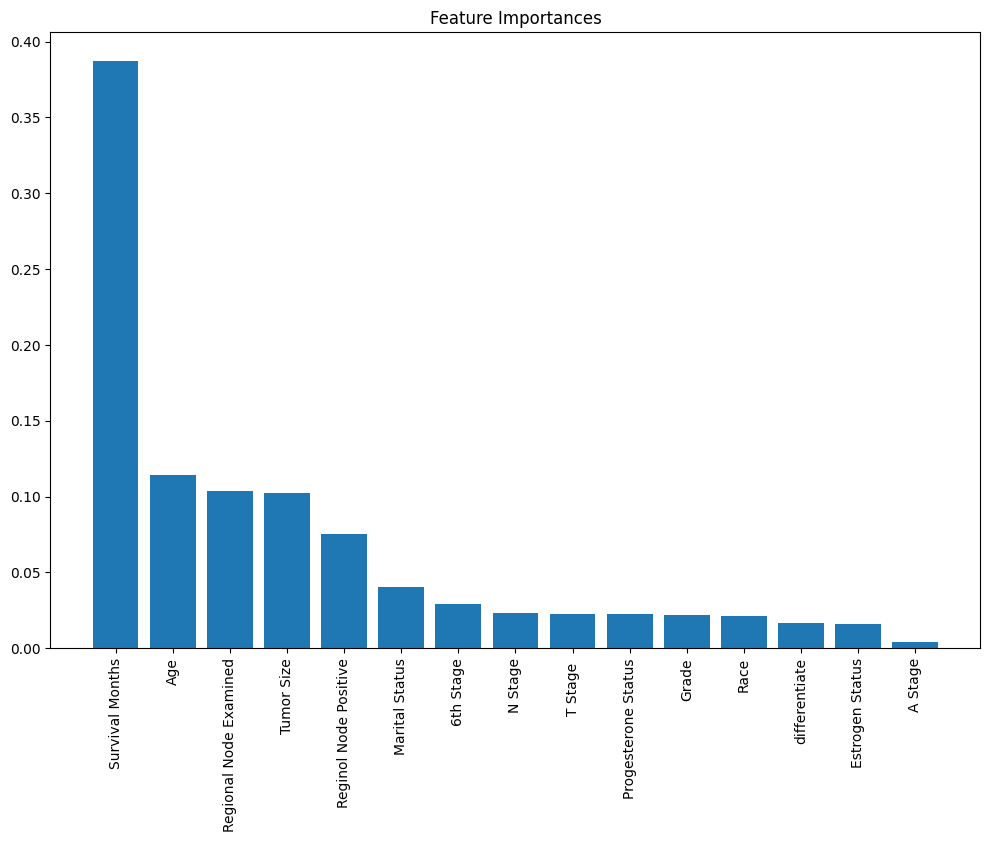

In [19]:
plt.figure(figsize=(12, 8))
plt.title("Feature Importances")
plt.bar(range(df_scaled.shape[1]), importances[indices], align="center")
plt.xticks(range(df_scaled.shape[1]), df_scaled.columns[indices], rotation=90)
plt.show()


In [20]:
sfm = SelectFromModel(rf, threshold='median')
sfm.fit(df_scaled, df['Status'])
X_selected = sfm.transform(df_scaled)

In [21]:
X = X_selected
y = df['Status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [23]:
log_reg = LogisticRegression(max_iter=1000)
cv_scores = cross_val_score(log_reg, X_train, y_train, cv=5, scoring='accuracy')
print(f'Logistic Regression CV Accuracy: {np.mean(cv_scores)}')

Logistic Regression CV Accuracy: 0.8849445095297481


In [24]:
rf = RandomForestClassifier(random_state=42)
cv_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy')
print(f'Random Forest CV Accuracy: {np.mean(cv_scores)}')

Random Forest CV Accuracy: 0.8909779171862994


In [25]:
svm = SVC(probability=True, random_state=42)
cv_scores = cross_val_score(svm, X_train, y_train, cv=5, scoring='accuracy')
print(f'SVM CV Accuracy: {np.mean(cv_scores)}')

SVM CV Accuracy: 0.8803251325850623


In [26]:
ensemble = VotingClassifier(estimators=[
    ('lr', LogisticRegression(max_iter=1000)),
    ('rf', RandomForestClassifier(random_state=42)),
    ('svm', SVC(probability=True, random_state=42))
], voting='soft')
ensemble.fit(X_train, y_train)
y_pred_ensemble = ensemble.predict(X_test)

In [27]:
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [28]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [29]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

In [30]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping, reduce_lr], verbose=1)

Epoch 1/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5832 - loss: 0.8842 - val_accuracy: 0.8546 - val_loss: 0.5065 - learning_rate: 0.0010
Epoch 2/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7343 - loss: 0.5772 - val_accuracy: 0.8564 - val_loss: 0.4064 - learning_rate: 0.0010
Epoch 3/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8112 - loss: 0.4496 - val_accuracy: 0.8688 - val_loss: 0.3582 - learning_rate: 0.0010
Epoch 4/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8317 - loss: 0.4389 - val_accuracy: 0.8688 - val_loss: 0.3400 - learning_rate: 0.0010
Epoch 5/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8448 - loss: 0.4263 - val_accuracy: 0.8670 - val_loss: 0.3407 - learning_rate: 0.0010
Epoch 6/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8710 - loss: 0.3631 - val_accuracy: 0.8706 - val_loss: 0.3359 - learning_rate: 0.0010
Epoch 7/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8577 - loss: 0.3737 - val_acc

In [31]:
y_pred_dl = model.predict(X_test)
y_pred_dl = (y_pred_dl > 0.5).astype(int)

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [32]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

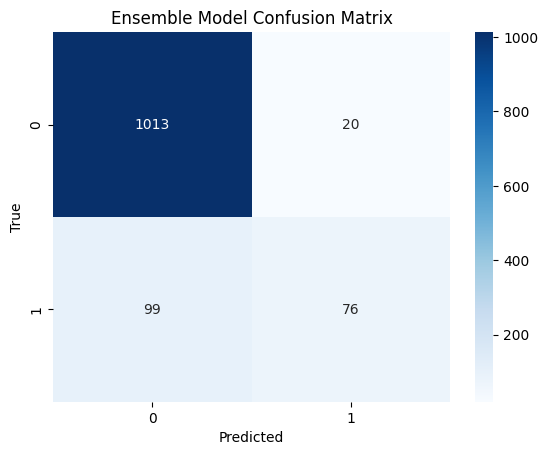

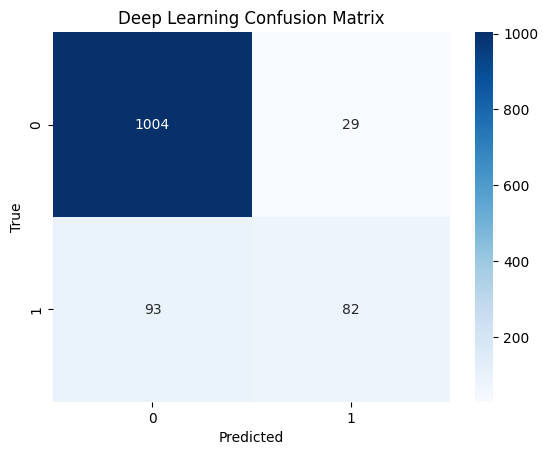

In [33]:
plot_confusion_matrix(y_test, y_pred_ensemble, 'Ensemble Model Confusion Matrix')
plot_confusion_matrix(y_test, y_pred_dl, 'Deep Learning Confusion Matrix')

In [34]:
def plot_roc_curve(y_true, y_pred, title):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

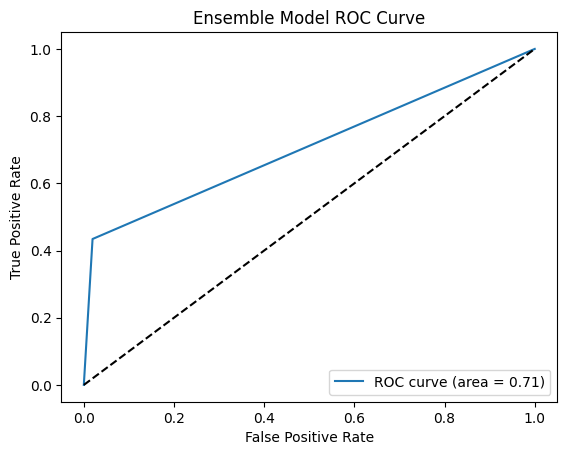

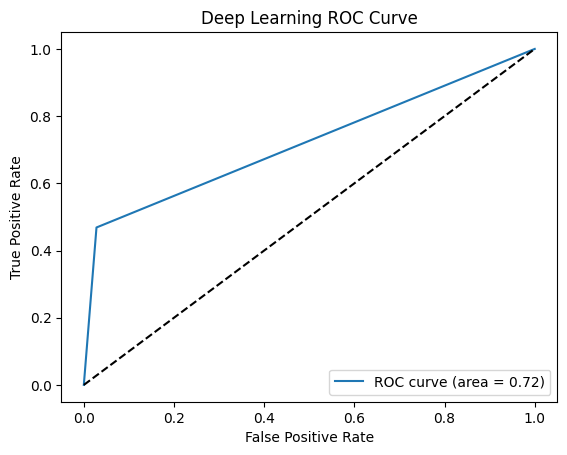

In [36]:
plot_roc_curve(y_test, y_pred_ensemble, 'Ensemble Model ROC Curve')
plot_roc_curve(y_test, y_pred_dl, 'Deep Learning ROC Curve')

In [37]:
def plot_precision_recall_curve(y_true, y_pred, title):
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    plt.plot(recall, precision, label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.legend(loc="lower left")
    plt.show()

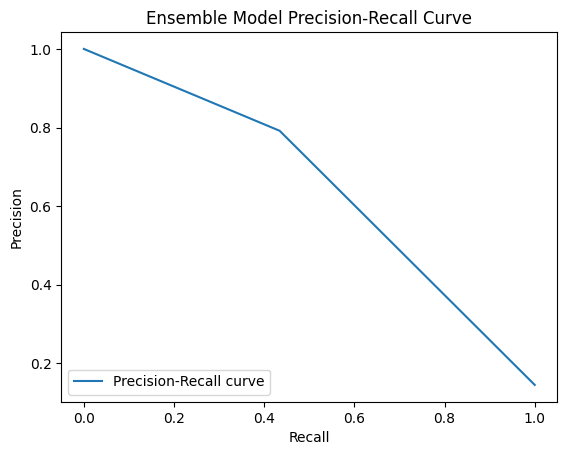

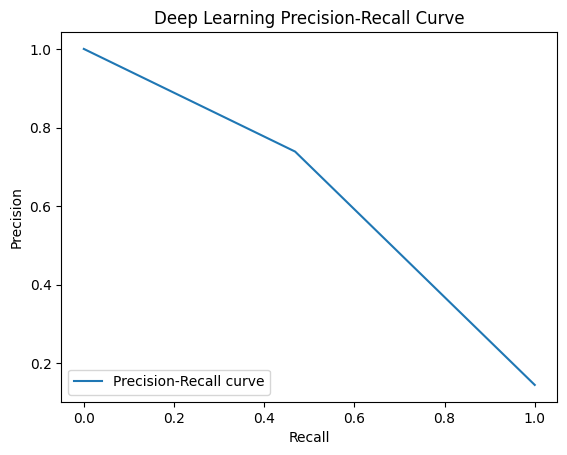

In [38]:
plot_precision_recall_curve(y_test, y_pred_ensemble, 'Ensemble Model Precision-Recall Curve')
plot_precision_recall_curve(y_test, y_pred_dl, 'Deep Learning Precision-Recall Curve')

In [39]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    max_depth = trial.suggest_int('max_depth', 10, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)

    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, random_state=42)
    return cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy').mean()

In [40]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
best_rf = RandomForestClassifier(**study.best_params, random_state=42)
best_rf.fit(X_train, y_train)

[I 2025-02-02 10:05:55,732] A new study created in memory with name: no-name-015f8dcb-a433-4a42-8289-6fbd485595fd
[I 2025-02-02 10:06:02,880] Trial 0 finished with value: 0.8959474950556163 and parameters: {'n_estimators': 434, 'max_depth': 22, 'min_samples_split': 7}. Best is trial 0 with value: 0.8959474950556163.
[I 2025-02-02 10:06:06,202] Trial 1 finished with value: 0.8938166861922576 and parameters: {'n_estimators': 165, 'max_depth': 12, 'min_samples_split': 5}. Best is trial 0 with value: 0.8959474950556163.
[I 2025-02-02 10:06:08,045] Trial 2 finished with value: 0.9005643525691898 and parameters: {'n_estimators': 119, 'max_depth': 25, 'min_samples_split': 10}. Best is trial 2 with value: 0.9005643525691898.
[I 2025-02-02 10:06:12,046] Trial 3 finished with value: 0.8959487547711726 and parameters: {'n_estimators': 258, 'max_depth': 34, 'min_samples_split': 7}. Best is trial 2 with value: 0.9005643525691898.
[I 2025-02-02 10:06:20,403] Trial 4 finished with value: 0.8970125845

RandomForestClassifier(max_depth=25, min_samples_split=10, n_estimators=119,
                       random_state=42)

In [41]:
def objective(trial):
    model = Sequential()
    model.add(Dense(trial.suggest_int('units_1', 64, 256), input_dim=X_train.shape[1], activation='relu'))
    model.add(Dropout(trial.suggest_float('dropout_1', 0.2, 0.5)))
    model.add(Dense(trial.suggest_int('units_2', 32, 128), activation='relu'))
    model.add(Dropout(trial.suggest_float('dropout_2', 0.2, 0.5)))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=trial.suggest_float('learning_rate', 1e-5, 1e-2)), loss='binary_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)
    return history.history['val_accuracy'][-1]

In [42]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
best_dl_params = study.best_params

[I 2025-02-02 10:10:40,779] A new study created in memory with name: no-name-fda41822-717c-42f6-af56-07f76eda30f0
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
[I 2025-02-02 10:10:58,733] Trial 0 finished with value: 0.8847517967224121 and parameters: {'units_1': 125, 'dropout_1': 0.3795200069971796, 'units_2': 103, 'dropout_2': 0.49351945512526546, 'learning_rate': 0.008110286856051953}. Best is trial 0 with value: 0.8847517967224121.
[I 2025-02-02 10:11:15,912] Trial 1 finished with value: 0.8829787373542786 and parameters: {'units_1': 114, 'dropout_1': 0.3538328047481558, 'units_2': 39, 'dropout_2': 0.39256242804459107, 'learning_rate': 0.006366661941069302}. Best is trial 0 with value: 0.88475179672241

In [43]:
model_tuned = Sequential()
model_tuned.add(Dense(best_dl_params['units_1'], input_dim=X_train.shape[1], activation='relu'))
model_tuned.add(Dropout(best_dl_params['dropout_1']))
model_tuned.add(Dense(best_dl_params['units_2'], activation='relu'))
model_tuned.add(Dropout(best_dl_params['dropout_2']))
model_tuned.add(Dense(1, activation='sigmoid'))

In [47]:
model_tuned.compile(optimizer=Adam(learning_rate=best_dl_params['learning_rate']), loss='binary_crossentropy', metrics=['accuracy'])

In [48]:
history_tuned = model_tuned.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping, reduce_lr], verbose=1)

Epoch 1/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8758 - loss: 0.3224 - val_accuracy: 0.8812 - val_loss: 0.3448 - learning_rate: 0.0061
Epoch 2/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8778 - loss: 0.3185 - val_accuracy: 0.8794 - val_loss: 0.3441 - learning_rate: 0.0061
Epoch 3/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8899 - loss: 0.3136 - val_accuracy: 0.8848 - val_loss: 0.3519 - learning_rate: 0.0061
Epoch 4/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9015 - loss: 0.2806 - val_accuracy: 0.8848 - val_loss: 0.3430 - learning_rate: 0.0061
Epoch 5/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8792 - loss: 0.3111 - val_accuracy: 0.8883 - val_loss: 0.3229 - learning_rate: 0.0061
Epoch 6/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8860 - loss: 0.2931 - val_accuracy: 0.8777 - val_loss: 0.3605 - learning_rate: 0.0061
Epoch 7/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8798 - loss: 0.3019 - val_ac

In [49]:
y_pred_dl_tuned = model_tuned.predict(X_test)
y_pred_dl_tuned = (y_pred_dl_tuned > 0.5).astype(int)

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


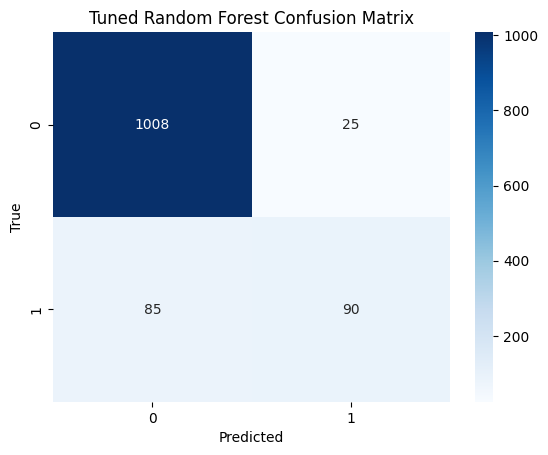

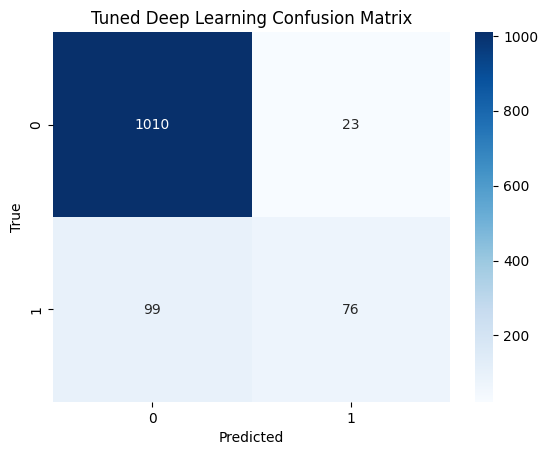

In [50]:
plot_confusion_matrix(y_test, best_rf.predict(X_test), 'Tuned Random Forest Confusion Matrix')
plot_confusion_matrix(y_test, y_pred_dl_tuned, 'Tuned Deep Learning Confusion Matrix')

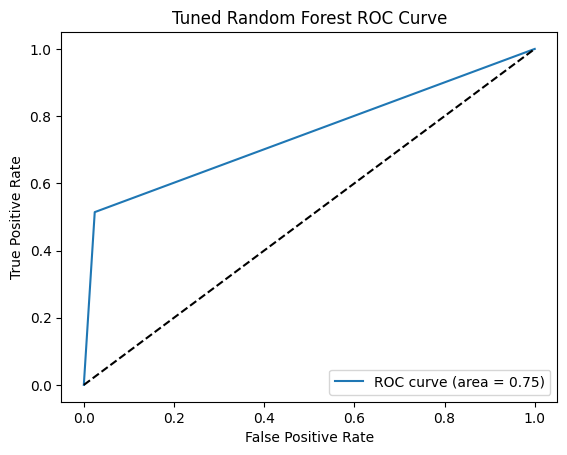

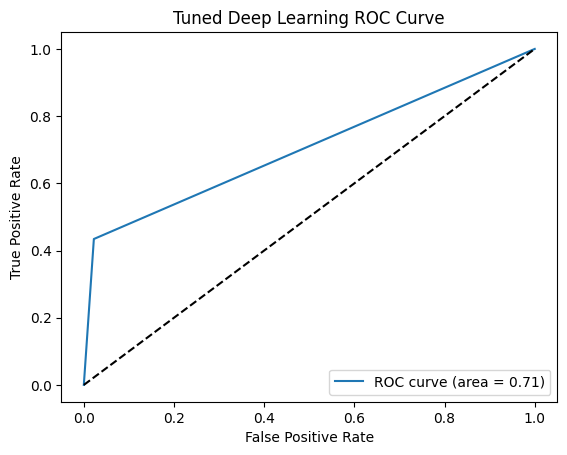

In [51]:
plot_roc_curve(y_test, best_rf.predict(X_test), 'Tuned Random Forest ROC Curve')
plot_roc_curve(y_test, y_pred_dl_tuned, 'Tuned Deep Learning ROC Curve')

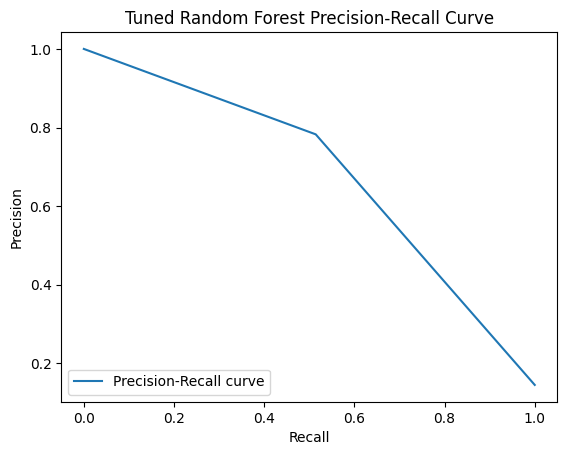

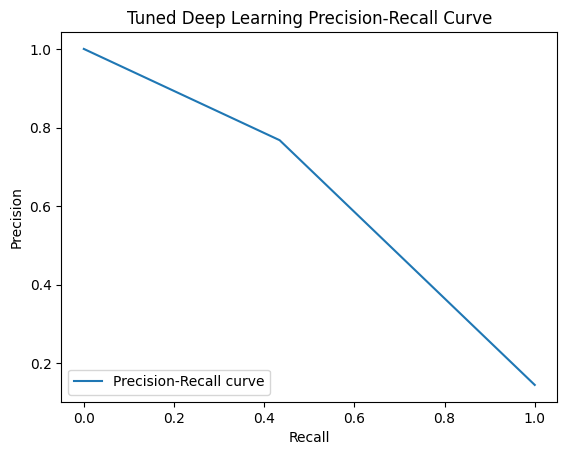

In [52]:
plot_precision_recall_curve(y_test, best_rf.predict(X_test), 'Tuned Random Forest Precision-Recall Curve')
plot_precision_recall_curve(y_test, y_pred_dl_tuned, 'Tuned Deep Learning Precision-Recall Curve')

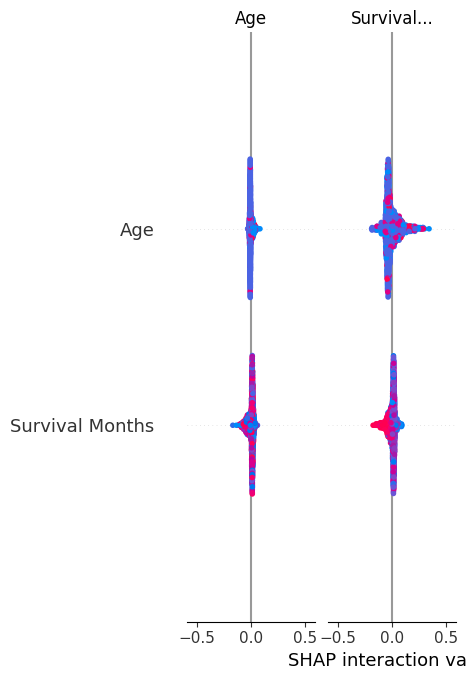

In [53]:
explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=df_scaled.columns[indices])

/usr/local/lib/python3.11/dist-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_829
Received: inputs=['Tensor(shape=(100, 8))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_829
Received: inputs=['Tensor(shape=(200, 8))']
  warnings.warn(msg)


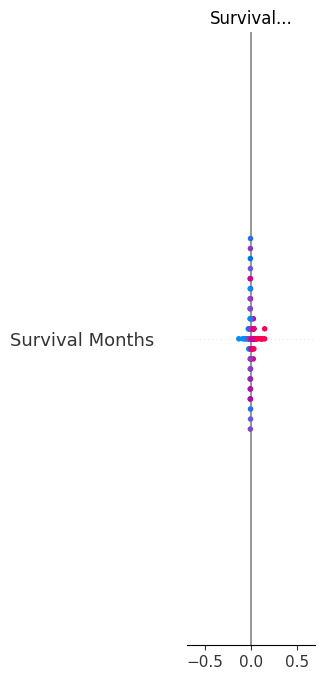

In [54]:
explainer = shap.DeepExplainer(model_tuned, X_train[:100])
shap_values = explainer.shap_values(X_test[:100])
shap.summary_plot(shap_values, X_test[:100], feature_names=df_scaled.columns[indices])


In [55]:
tpot = TPOTClassifier(generations=5, population_size=20, verbosity=2, random_state=42)
tpot.fit(X_train, y_train)
print(tpot.score(X_test, y_test))

is_classifier
is_regressor
is_classifier
is_regressor


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1230: FutureWarning: passing a class to None is deprecated and will be removed in 1.8. Use an instance of the class instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1270: FutureWarning: passing a class to None is deprecated and will be removed in 1.8. Use an instance of the class instead.
  warnings.warn(


is_classifier
is_regressor
is_classifier
is_classifier
is_classifier
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_classifier
is_classifier
is_classifier
is_classifier
is_classifier
is_classifier
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_classifier
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier


Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.8977249537054532

Generation 2 - Current best internal CV score: 0.8995011526397338

Generation 3 - Current best internal CV score: 0.9005675018580804

Generation 4 - Current best internal CV score: 0.9005675018580804

Generation 5 - Current best internal CV score: 0.9005675018580804

Best pipeline: RandomForestClassifier(MinMaxScaler(CombineDFs(input_matrix, ZeroCount(input_matrix))), bootstrap=True, criterion=gini, max_features=0.2, min_samples_leaf=8, min_samples_split=4, n_estimators=100)
0.9105960264900662
